# Settings

In [1]:
loss_ckpt_path = "/home/borth/sketch2shape/logs/train_latent_encoder/runs/2024-02-15_22-31-15/checkpoints/epoch_019.ckpt"
# loss_ckpt_path = "/home/borth/sketch2shape/checkpoints/siamese.ckpt"
shape_view_id = 11
shape_k = 16

In [ ]:
from lib.utils.config import load_config
from lib.data.sampler import ChunkSampler
from lib.data.metainfo import MetaInfo

cfg = load_config(
    "train_loss", ["+experiment/train_loss=latent_encoder_shapenet_chair_4096"]
)
metainfo = MetaInfo(cfg.data.data_dir, split="val_latent")
metainfo.load_snn()
sampler = ChunkSampler(metainfo.snn_labels, chunk_size=1)
max([i for i in sampler]), len([i for i in sampler])

# Utils

In [2]:
import numpy as np
from lib.data.metainfo import MetaInfo
from lib.data.transforms import BaseTransform
import hydra
from lib.utils.config import load_config
import matplotlib.pyplot as plt
import torch
from torch.nn.functional import cosine_similarity
from tqdm import tqdm
from lib.visualize.image import image_grid


def transform(normal):
    _transform = BaseTransform()
    return _transform(normal).to("cuda")


def plot_images(images, size: int = 4):
    if isinstance(images, list):
        _, axes = plt.subplots(1, len(images), figsize=(size, size))
        for ax, image in zip(axes, images):
            ax.imshow(image)
            ax.axis("off")  # Turn off axis
        plt.show()
    else:
        plt.figure(figsize=(size, size))
        plt.imshow(images)
        plt.show()


def siamese_loss(emb_1, emb_2):
    return 1 - cosine_similarity(emb_1, emb_2)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Load Models

100%|██████████| 4096/4096 [00:21<00:00, 191.96it/s]


siamese_loss(sketch_3_emb, rendered_normal_3_emb)=tensor([0.0142], device='cuda:0')


/home/borth/miniconda3/envs/sketch2shape/lib/python3.11/site-packages/torchvision/transforms/v2/functional/_type_conversion.py:14: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  output = torch.from_numpy(inpt).permute((2, 0, 1)).contiguous()


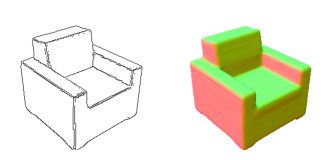

siamese_loss(sketch_5_emb, rendered_normal_3_emb)=tensor([1.0964], device='cuda:0')


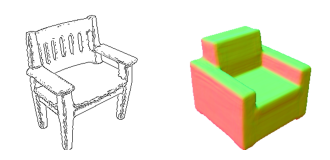

In [4]:
cfg = load_config("optimize_sketch", ["+dataset=shapenet_chair_4096"])
metainfo = MetaInfo(cfg.data.data_dir)

cfg.loss_ckpt_path = loss_ckpt_path
cfg.model.shape_k = shape_k
cfg.model.shape_view_id = shape_view_id
cfg.model.shape_init = True
cfg.model.obj_id = metainfo.obj_ids[0]
model = hydra.utils.instantiate(cfg.model).to("cuda")

sketch_3 = np.asarray(metainfo.load_image(3, 11, 0))
sketch_5 = np.asarray(metainfo.load_image(5, 11, 0))
model.latent = model.deepsdf.lat_vecs.weight[3]
rendered_normal_3 = model.capture_camera_frame().detach().cpu().numpy()

rendered_normal_3_emb = model.loss(transform(rendered_normal_3)[None, ...])
sketch_3_emb = model.loss(transform(sketch_3)[None, ...])
sketch_5_emb = model.loss(transform(sketch_5)[None, ...])

print(f"{siamese_loss(sketch_3_emb, rendered_normal_3_emb)=}")
plot_images([sketch_3, rendered_normal_3])

print(f"{siamese_loss(sketch_5_emb, rendered_normal_3_emb)=}")
plot_images([sketch_5, rendered_normal_3])

# Qualitative Analysis of Possible Rendering Improvement

In [ ]:
from torch.nn.functional import l1_loss

shape_id = 4244

# gt_emb = model.deepsdf.lat_vecs.weight[shape_id]
sketch = np.asarray(metainfo.load_image(shape_id, 11, 0))
sketch_emb = model.loss(transform(sketch)[None, ...])[0]
model.latent = sketch_emb
rendered_normal = model.capture_camera_frame().detach().cpu().numpy()
rendered_normal_emb = model.loss(transform(rendered_normal)[None, ...])[0]

# model.latent = gt_emb
gt_rendered_normal = model.capture_camera_frame().detach().cpu().numpy()
gt_rendered_normal_emb = model.loss(transform(gt_rendered_normal)[None, ...])[0]

# loss_gt_sketch = l1_loss(gt_emb, sketch_emb).item()
loss_sketch_normal = l1_loss(sketch_emb, rendered_normal_emb).item()
loss_sketch_gt_normal = l1_loss(sketch_emb, gt_rendered_normal_emb).item()
# print(f"loss_gt_sketch={loss_gt_sketch:.4f}")
print(f"loss_sketch_normal={loss_sketch_normal:.4f}")
print(f"loss_sketch_gt_normal={loss_sketch_gt_normal:.4f}")
plot_images([sketch, rendered_normal, gt_rendered_normal], size=8)

# Quantitative Analysis Of Possible Improvement

In [ ]:
from torch.nn.functional import l1_loss

loss_gt_sketch = []
loss_sketch_normal = []
loss_sketch_gt_normal = []
for shape_id in tqdm(range(3968, 3968 + 128, 1)):  # validation split
    # for shape_id in tqdm(range(256)):  # train split
    gt_emb = model.deepsdf.lat_vecs.weight[shape_id]
    sketch = np.asarray(metainfo.load_image(shape_id, 11, 0))
    sketch_emb = model.loss(transform(sketch)[None, ...])[0]
    model.latent = sketch_emb
    rendered_normal = model.capture_camera_frame().detach().cpu().numpy()
    rendered_normal_emb = model.loss(transform(rendered_normal)[None, ...])[0]

    model.latent = gt_emb
    gt_rendered_normal = model.capture_camera_frame().detach().cpu().numpy()
    gt_rendered_normal_emb = model.loss(transform(gt_rendered_normal)[None, ...])[0]

    loss_gt_sketch.append(l1_loss(gt_emb, sketch_emb).item())
    loss_sketch_normal.append(l1_loss(sketch_emb, rendered_normal_emb).item())
    loss_sketch_gt_normal.append(l1_loss(sketch_emb, gt_rendered_normal_emb).item())

mean_loss_gt_sketch = np.array(loss_gt_sketch).mean()
mean_loss_sketch_normal = np.array(loss_sketch_normal).mean()
mean_loss_sketch_gt_normal = np.array(loss_sketch_gt_normal).mean()

print(f"mean_loss_gt_sketch={mean_loss_gt_sketch:.4f}")
print(f"mean_loss_sketch_normal={mean_loss_sketch_normal:.4f}")
print(f"mean_loss_sketch_gt_normal={mean_loss_sketch_gt_normal:.4f}")
print(f"mean_gain={(mean_loss_sketch_normal-mean_loss_sketch_gt_normal):.4f}")

# Difference Closest Latent Retrieval

In [ ]:
idxs = torch.norm(
    model.deepsdf.lat_vecs.weight[0] - model.deepsdf.lat_vecs.weight, dim=-1
)
torch.argsort(idxs)[:10]

In [ ]:
std = model.shape_latents.std(0)
mean = model.shape_latents.mean(0)
loss = []
images = []
for idx in model.shape_idx:
    reg_loss = torch.nn.functional.l1_loss(
        model.deepsdf.lat_vecs.weight[idx], model.deepsdf.lat_vecs.weight[2]
    )
    model.latent = model.deepsdf.lat_vecs.weight[idx]
    rendered_normal = model.capture_camera_frame().detach().cpu().numpy()
    images.append(rendered_normal)
    rendered_normal_emb = model.loss(transform(rendered_normal_3)[None, ...])
    loss.append(reg_loss.mean().item())
    print(idx, reg_loss.mean())
mean_loss = np.array(loss).mean()
print(f"mean_loss={mean_loss:.04}")
for l in loss:
    print(f"{l:.03}")
plot_images(images, size=64)

# Gray Scale Images

In [ ]:
model.latent = model.deepsdf.lat_vecs.weight[3]
model.deepsdf.create_camera(azim=40, elev=-30)
rendered_normal = model.capture_camera_frame().detach().cpu().numpy()
mean = rendered_normal.mean(-1)
mean = np.stack([mean, mean, mean], axis=-1)
rendered_gray_emb = model.loss(transform(mean)[None, ...])
loss = siamese_loss(rendered_gray_emb, sketch_3_emb)
print(loss)
plot_images(mean)

# Quantitative/Qualitative Loss Analysis

In [ ]:
# settings
start_latent_ids = [0, 2317, 189, 837, 2733, 2785, 3928]  # chair nn
# start_latent_ids = [3, 3385, 2801, 1962, 1058, 782, 1328]  # couch nn
# start_latent_ids = [3, 0, 1, 2, 4, 5, 6] # couch far
# start_latent_ids = [3, 0, 1, 2, 4, 5, 6] # couch far
# start_latent_ids = [0, 5]  # couch far
end_latent_id = 0
sketch_view = 11
traversal_steps = 20
image_skip = 2
azims = [40]
elevs = [-30]

# fetch and encode the sketch
sketch = metainfo.load_image(end_latent_id, sketch_view, 0)
sketch_emb = model.loss(transform(sketch)[None, ...])

image_trajectories = []
loss_trajectories = []
for idx, start_latent_id in enumerate(start_latent_ids):
    image_trajectory = [sketch]
    loss_trajectory = []
    desc = f"{idx+1}/{len(start_latent_ids)}"
    for t in tqdm(np.linspace(1, 0, traversal_steps), desc=desc):
        start_latent = model.deepsdf.lat_vecs.weight[start_latent_id]
        end_latent = model.deepsdf.lat_vecs.weight[end_latent_id]
        model.latent = t * start_latent + (1 - t) * end_latent

        # calculate the mean loss from all the views
        loss = []
        for azim in azims:
            for elev in elevs:
                model.deepsdf.create_camera(azim=azim, elev=elev)
                rendered_normal = model.capture_camera_frame().detach().cpu().numpy()
                # mean = rendered_normal.mean(-1)
                # rendered_normal = np.stack([mean, mean,mean], axis=-1)
                rendered_normal_emb = model.loss(transform(rendered_normal)[None, ...])
                snn_loss = siamese_loss(sketch_emb, rendered_normal_emb)
                loss.append(snn_loss)
                image_trajectory.append(rendered_normal)
        loss = torch.stack(loss).mean()

        # add the loss to the trajectory
        loss_trajectory.append(loss.detach().cpu().numpy())
    loss_trajectories.append(loss_trajectory)
    image_trajectories.append(image_trajectory)

# plot the images
for image_trajectory in image_trajectories:
    trajectory = []
    for idx, img in enumerate(image_trajectory):
        if idx == 0 or (idx - 1) % image_skip == 0:
            trajectory.append(img)
    plot_images(trajectory, size=16)

# plot the loss curves
for obj_id, loss_trajectory in zip(start_latent_ids, loss_trajectories):
    plt.plot(
        np.linspace(0, 1, traversal_steps),
        np.stack(loss_trajectory),
        label=obj_id,
    )
    plt.legend(loc="upper right")
plt.ylabel("siamese_loss")
plt.xlabel("traversal_steps")
plt.show()

x = np.linspace(0, 1, 20)
mean = np.stack(loss_trajectories).mean(0)
std = np.stack(loss_trajectories).std(0)
plt.plot(x, mean)
plt.fill_between(x, (mean - std), (mean + std), color="b", alpha=0.1)
plt.ylabel("siamese_loss")
plt.xlabel("traversal_steps")

# Outlier Removal

In [ ]:
model.latent = model.deepsdf.lat_vecs.weight[0]
normal = model.capture_camera_frame().detach().cpu().numpy()
normal_emb = model.loss(transform(normal)[None, ...])
print(f"{siamese_loss(sketch_3_emb, normal_emb)=}")
plot_images([sketch_3, normal])

In [ ]:
"""
tensor(2549, device='cuda:0') tensor(0.6049, device='cuda:0')
tensor(1328, device='cuda:0') tensor(1.4948, device='cuda:0')
tensor(1898, device='cuda:0') tensor(0.6908, device='cuda:0')
tensor(962, device='cuda:0') tensor(0.6423, device='cuda:0')
tensor(535, device='cuda:0') tensor(0.8771, device='cuda:0')
tensor(755, device='cuda:0') tensor(0.4972, device='cuda:0')
tensor(2432, device='cuda:0') tensor(1.8280, device='cuda:0')
tensor(3089, device='cuda:0') tensor(0.9243, device='cuda:0')
tensor(3885, device='cuda:0') tensor(1.6862, device='cuda:0')
tensor(1447, device='cuda:0') tensor(1.0207, device='cuda:0')
tensor(3195, device='cuda:0') tensor(0.8885, device='cuda:0')
tensor(2207, device='cuda:0') tensor(0.7391, device='cuda:0')
tensor(277, device='cuda:0') tensor(0.7135, device='cuda:0')
tensor(1058, device='cuda:0') tensor(0.6626, device='cuda:0')
tensor(841, device='cuda:0') tensor(1.0481, device='cuda:0')
tensor(1637, device='cuda:0') tensor(0.6819, device='cuda:0')
"""

model.latent = model.deepsdf.lat_vecs.weight[3885]
normal = model.capture_camera_frame().detach().cpu().numpy()
plot_images(normal)

mean = model.shape_latents.mean(0)
std = model.shape_latents.std(0)

good_latents = []
for i in range(4096):
    latent = model.deepsdf.lat_vecs.weight[i]
    reg_loss = ((mean - latent) / std).pow(2).mean()
    if reg_loss <= 1.0 and i != 3:
        good_latents.append(latent)

for i in range(5):
    latent = model.deepsdf.lat_vecs.weight[i]
    reg_loss = ((mean - latent) / std).pow(2).mean()
    print("init", i, reg_loss)

mean = torch.stack(good_latents).mean(0)
std = torch.stack(good_latents).std(0)
for i in range(5):
    latent = model.deepsdf.lat_vecs.weight[i]
    reg_loss = ((mean - latent) / std).pow(2).mean()
    print("good", i, reg_loss)

In [ ]:
for i in range(4096):
    latent = model.deepsdf.lat_vecs.weight[i]
    reg_loss = ((mean - latent) / std).pow(2).mean()
    if reg_loss <= 1.0:
        print(i, reg_loss)

In [ ]:
model.latent = model.deepsdf.lat_vecs.weight[1962]
normal = model.capture_camera_frame().detach().cpu().numpy()
plot_images(normal)
# mean = model.shape_latents.mean(0)
# std = model.shape_latents.std(0)
# mean = torch.stack(good_latents).mean(0)
# std = torch.stack(good_latents).std(0)

((mean - latent) / std).pow(2).mean()

# Optimize Latent Code (Simple)

In [ ]:
start_latent_id = 3385
end_latent_id = 3
optim_steps = 10

t = torch.tensor(1.0, dtype=torch.float32).to("cuda")
t.requires_grad = True
start_latent = model.deepsdf.lat_vecs.weight[start_latent_id]
start_latent.requires_grad = True
end_latent = model.deepsdf.lat_vecs.weight[end_latent_id]
end_latent.requires_grad = True

optimizer = torch.optim.Adam([t], lr=0.1)

sketch = metainfo.load_image(end_latent_id, 11, 0)
sketch_emb = model.loss(transform(sketch)[None, ...])

image_trajectory = [np.asarray(sketch)]
loss_trajectory = []
reg_loss_trajectory = []
t_trajectory = []
with tqdm(total=optim_steps) as pbar:
    for step in range(optim_steps):
        model.latent = t * start_latent + (1 - t) * end_latent
        points, surface_mask = model.deepsdf.sphere_tracing(
            latent=model.latent,
            points=model.deepsdf.camera_points,
            rays=model.deepsdf.camera_rays,
            mask=model.deepsdf.camera_mask,
        )
        rendered_normal = model.deepsdf.render_normals(
            latent=model.latent,
            points=points,
            mask=surface_mask,
        )  # (H, W, 3)
        normal = model.deepsdf.normal_to_siamese(rendered_normal)  # (1, 3, H, W)
        normal_emb = model.loss(normal)  # (1, D)

        snn_loss = siamese_loss(sketch_emb, normal_emb)

        std = model.shape_latents.std(0)
        mean = model.shape_latents.mean(0)
        reg_loss = ((model.latent.clone() - mean) / std).pow(2)
        reg_loss_trajectory.append(reg_loss.mean().item())

        loss_trajectory.append(snn_loss.item())
        t_trajectory.append(t.item())
        image_trajectory.append(rendered_normal.detach().cpu().numpy())

        snn_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        pbar.set_postfix({"t": t.item()})
        pbar.update(1)

# images
plot_images(image_trajectory, size=16)

# loss
plt.plot(
    np.linspace(0, 1, optim_steps),
    np.stack(loss_trajectory),
    label=obj_id,
)
plt.legend(loc="upper right")
plt.ylabel("siamese_loss")
plt.xlabel("optim_steps")
plt.show()

plt.plot(
    np.linspace(0, 1, optim_steps),
    np.stack(reg_loss_trajectory),
    label=obj_id,
)
plt.legend(loc="upper right")
plt.ylabel("reg_loss")
plt.xlabel("optim_steps")
plt.show()

plt.plot(
    np.linspace(0, 1, optim_steps),
    np.stack(t_trajectory),
    label=obj_id,
)
plt.legend(loc="upper right")
plt.ylabel("t")
plt.xlabel("optim_steps")
plt.show()

# Data Generation

## Random from Chair

In [ ]:
# start_latent_ids = [0, 3176, 2110, 2733, 2317, 94, 3831]  # chair nn
mean = model.deepsdf.lat_vecs.weight[5]
std = model.deepsdf.lat_vecs.weight.std(0)
latent = mean + torch.randn_like(std) * std * 0.3
print(l1_loss(latent, mean))
model.latent = latent
normal = model.capture_camera_frame().detach().cpu().numpy()
plot_images(normal)

## Interpolation Chair

In [ ]:
start_latent_ids = [0, 2317, 189, 837, 2733, 2785, 3928]  # chair nn
start_latent_id = 1
mean = model.deepsdf.lat_vecs.weight[0]
images = []
for t in np.linspace(0, 1, 11):
    latent = t * model.deepsdf.lat_vecs.weight[start_latent_id] + (1 - t) * mean
    model.latent = latent
    normal = model.capture_camera_frame().detach().cpu().numpy()
    images.append(normal)
plot_images(images, size=32)

In [ ]:
import cv2 as cv


def to_sketch(img):
    img = cv.Canny(
        (img * 255).astype(np.uint8),
        100,
        150,
        L2gradient=True,
        apertureSize=3,
    )
    img = cv.bitwise_not(img)
    return np.stack([img, img, img], axis=-1).astype(np.float32) / 255


for i in torch.randint(4096, (100,)):
    t = torch.normal(torch.tensor(0.25), torch.tensor(0.1))
    t = torch.clamp(t, 0.0, 0.5)
    azim = torch.normal(torch.tensor(30.0), torch.tensor(5))
    elev = torch.normal(torch.tensor(-20.0), torch.tensor(5))
    model.deepsdf.create_camera(azim=azim, elev=elev)
    print(f"{t=}")
    print(f"{azim=}")
    print(f"{elev=}")
    source_id = 0
    target_id = i

    source_latent = model.deepsdf.lat_vecs.weight[source_id]
    model.latent = source_latent
    source_normal = model.capture_camera_frame().detach().cpu().numpy()

    target_latent = model.deepsdf.lat_vecs.weight[target_id]
    model.latent = target_latent
    target_normal = model.capture_camera_frame().detach().cpu().numpy()

    interpolated_latent = (1 - t) * source_latent + t * target_latent
    model.latent = interpolated_latent
    interpolated_normal = model.capture_camera_frame().detach().cpu().numpy()

    print(l1_loss(source_latent, target_latent))
    plot_images(
        [
            source_normal,
            target_normal,
            interpolated_normal,
            to_sketch(interpolated_normal),
        ],
        size=8,
    )

# Use the Preprocess Function

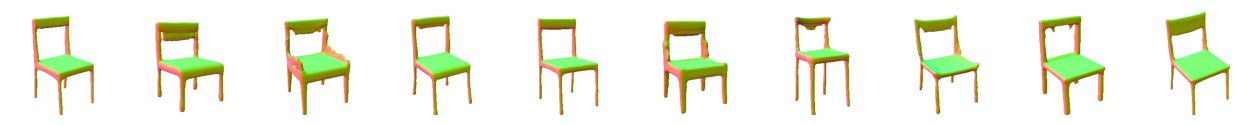

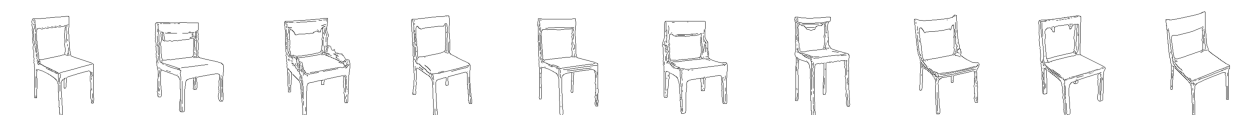

In [8]:
from lib.data.preprocess import PreprocessRenderings
cfg = load_config("optimize_sketch", ["+dataset=shapenet_chair_4096"])
metainfo = MetaInfo(cfg.data.data_dir)
preprocess = PreprocessRenderings(
    data_dir="/home/borth/sketch2shape/data/shapenet_chair_4096",
    deepsdf_ckpt_path="/home/borth/sketch2shape/checkpoints/deepsdf.ckpt",
    n_renderings=10,
)
normals, sketches, config = preprocess.preprocess(obj_id=metainfo.obj_ids[17])
plot_images(normals, size=16)
plot_images(sketches, size=16)

In [3]:
source_latent = model.deepsdf.lat_vecs.weight[17]
model.latent = source_latent
source_normal = model.capture_camera_frame().detach().cpu().numpy()
plot_images(source_normal)

NameError: name 'model' is not defined

In [42]:
cfg = load_config("preprocess_data", ["dataset=shapenet_chair_16"])
metainfo = MetaInfo(cfg.data.data_dir)

In [5]:
config = metainfo.load_rendered_config(metainfo.obj_ids[10])
config

FileNotFoundError: [Errno 2] No such file or directory: '/home/borth/sketch2shape/data/shapenet_chair_4096/shapes/21f2927b04e2f22830ddb6ead95f49cc/rendered_config.csv'